# NOTEBOOK POUR L'ÉVALUATION DU CORPUS CONSTITUÉ
> TP5

In [17]:
#Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import scipy
import spacy
import numpy as np
from datasets import load_dataset

In [21]:
#Chargement du corpus
dataset = load_dataset("parquet", data_files="articles_cleaned.parquet", split="train")

nlp = spacy.load("fr_core_news_md")

#Affichage des informations du dataset
dataset

Dataset({
    features: ['text', 'summary'],
    num_rows: 29
})

## Mesure de la corrélation entre les deux variables

In [27]:
#Initialisation de deux listes (pour texte et résumé) pour récupérer les valeurs et y appliquer le calcul de corrélation
text_lengths = []
summary_lengths = []

for i in dataset:
    text_length = len(nlp(i["text"]))
    summary_length = len(nlp(i["summary"]))
    text_lengths.append(text_length)
    summary_lengths.append(summary_length)

#Impression des deux listes crées
# print(text_lengths)
# print(summary_lengths)

--------------------------------
Mode: two-sided
Pearson Correlation: +0.0119; p-value: +0.9513
Spearman Correlation: -0.0301; p-value: +0.8768
--------------------------------
Mode: greater
Pearson Correlation: +0.0119; p-value: +0.4756
Spearman Correlation: -0.0301; p-value: +0.5616
--------------------------------
Mode: less
Pearson Correlation: +0.0119; p-value: +0.5244
Spearman Correlation: -0.0301; p-value: +0.4384


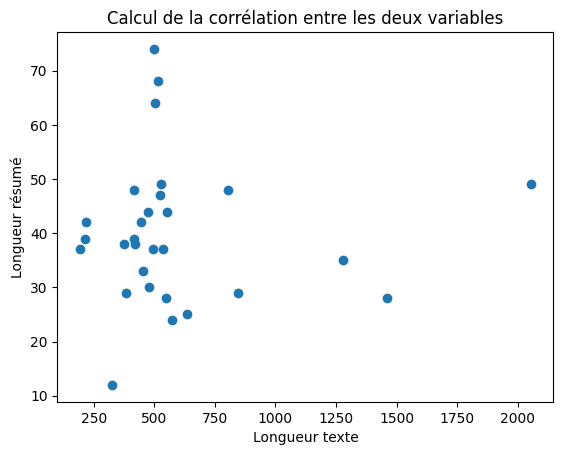

In [26]:
#Calcul de la corrélation entre les deux variables : longueur des textes et longueur des résumés
for mode in ["two-sided", "greater", "less"]:
    print("-" * 32)
    print("Mode:", mode)
    pearson_corr, pearson_pvalue = scipy.stats.pearsonr(text_lengths, summary_lengths, alternative=mode)
    print(f"Pearson Correlation: {pearson_corr:+.4f}; p-value: {pearson_pvalue:+.4f}")
    spearman_corr, spearman_pvalue = scipy.stats.spearmanr(text_lengths, summary_lengths, alternative=mode)
    print(f"Spearman Correlation: {spearman_corr:+.4f}; p-value: {spearman_pvalue:+.4f}")

#Création du graphique de corrélation
plt.scatter(text_lengths, summary_lengths)
plt.xlabel("Longueur texte")
plt.ylabel("Longueur résumé")
plt.title("Calcul de la corrélation entre les deux variables")
plt.show()

Interprétations : 

- mode **two-sided** _(mode par défaut)_ qui teste l'hypothèse nulle selon laquelle la corrélation exercée entre les deux variables est nulle. Par conséquent, puisque la p-value dans notre cas est > 0.05, la corrélation entre les deux variables n'est pas significative.

- mode **greater** _(hypothèse alternative)_ qui teste l'hypothèse selon laquelle la corrélation entre les deux variables est positive. Dans notre cas, la corrélation n'est pas significative.

- mode **less** _(hypothèse alternative)_ qui teste l'hypothèse selon laquelle la corrélation entre les deux variables est négative. Dans notre cas, la corrélation n'est pas significative non plus.

Finalement, nous remarquons que dans les 3 modes distincts, il n'y a pas de corrélation significative entre les longueurs des textes et celle des résumés du corpus.

## Élimination des données abérrantes (utilisation de la méthode IQR = écart inter-quartile)

In [30]:
#Pour les textes (=contenus des articles)
q1_text = np.percentile(text_lengths, 25)
q3_text = np.percentile(summary_lengths, 75)

iqr_text = q3_text - q1_text

#Initialisation des seuils inférieur et supérieur
seuil_inférieur_text = q1_text - 1.5 * iqr_text
seuil_supérieur_text = q3_text + 1.5 * iqr_text

#Suppression des données aberrantes pour les textes
filtre_text_lengths = []
for length in text_lengths:
    if seuil_inférieur_text <= length <= seuil_supérieur_text:
        filtre_text_lengths.append(length)

#print(filtre_text_lengths)

[]


In [34]:
#Même chose pour les résumés
q1_summary = np.percentile(summary_lengths, 25)
q3_summary = np.percentile(summary_lengths, 75)

iqr_summary = q3_summary - q1_summary

#Initialisation des seuils inférieur et supérieur
seuil_inférieur_summary = q1_summary - 1.5 * iqr_summary
seuil_supérieur_summary = q3_summary + 1.5 * iqr_summary

#Suppression des données aberrantes pour les textes
filtre_summary_lengths = []
for length in summary_lengths:
    if seuil_inférieur_summary <= length <= seuil_supérieur_summary:
        filtre_summary_lengths.append(length)

# print(filtre_summary_lengths)

Problème ici : nous remarquons que toutes les valeurs sont considérées comme aberrantes.  
Je vais donc plutôt enlever les paires texte-résumé qui ont un ratio de compression trop élevé.

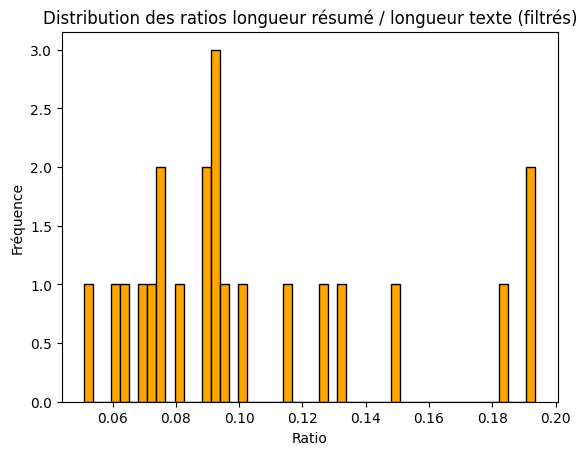

In [46]:
#Initialisation de la liste pour les ratios de compression
compression_ratio = []
for summary_len, text_len in zip(summary_lengths, text_lengths):
    if text_len > 0:
        ratio = summary_len / text_len
    else:
        ratio = 0
    compression_ratio.append(ratio)

#Initialisation des seuils pour le ratio de compression
seuil_inférieur = 0.05 #Au moins 5% de la longueur des textes
seuil_supérieur = 0.4 #Pas de dépassement au delà de 40% de la longueur des textes

#Initialisation des listes
filtre_texts = []
filtre_summaries = []
filtre_text_lengths = []
filtre_summary_lengths = []
filtre_ratios = []

for text, summary, text_len, summary_len, ratio in zip(dataset['text'], dataset['summary'], text_lengths, summary_lengths, compression_ratio):
    if seuil_inférieur <= ratio <= seuil_supérieur:
        filtre_texts.append(text)
        filtre_summaries.append(summary)
        filtre_text_lengths.append(text_len)
        filtre_summary_lengths.append(summary_len)
        filtre_ratios.append(ratio)

plt.hist(filtre_ratios, bins=50, color='orange', edgecolor='black')
plt.title('Distribution des ratios longueur résumé / longueur texte (filtrés)')
plt.xlabel('Ratio')
plt.ylabel('Fréquence')
plt.show()

Pearson correlation: +0.2528; p-value: +2.5638e-01
Spearman correlation: +0.2864; p-value: +1.9622e-01


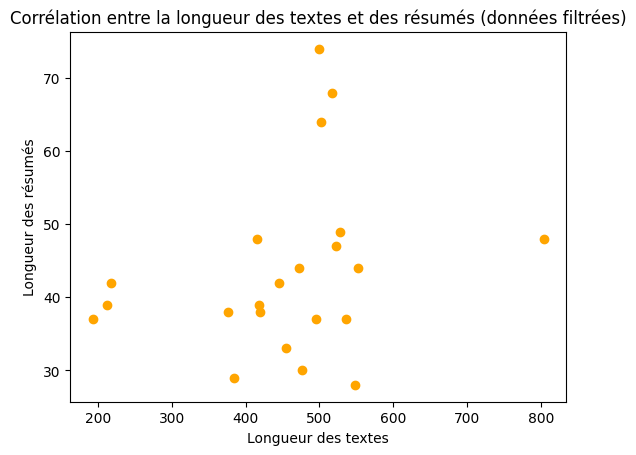

In [53]:
#Nouvelle visualisation de la corrélation, pour voir si les données aberrantes ont bien été écartées
pearson_corr, pearson_p = scipy.stats.pearsonr(filtre_text_lengths, filtre_summary_lengths)
spearman_corr, spearman_p = scipy.stats.spearmanr(filtre_text_lengths, filtre_summary_lengths)

#Résultats des corrélations
print(f"Pearson correlation: {pearson_corr:+.4f}; p-value: {pearson_p:+.4e}")
print(f"Spearman correlation: {spearman_corr:+.4f}; p-value: {spearman_p:+.4e}")

#Visualisation de la corrélation
plt.scatter(filtre_text_lengths, filtre_summary_lengths, color='orange')
plt.title("Corrélation entre la longueur des textes et des résumés (données filtrées)")
plt.xlabel("Longueur des textes")
plt.ylabel("Longueur des résumés")
plt.show()

## Augmentation des données
> pour augmenter les données de mon corpus, je vais utiliser une technique de génération de texte, je vais utiliser le modèle **RoBERTa** de la bibliothèque HuggingFace Transformers. 

In [55]:
#Importation des bibliothèques
from transformers import pipeline
import pandas as pd

In [57]:
#Chargement du corpus
df = pd.read_parquet("articles_cleaned.parquet")
texte_depart = df["text"].iloc[0]

In [9]:
#Chargement du modèle RoBERTa 
text_generator = pipeline("text-generation", model="roberta-base", device="cpu")
generated_text = text_generator(texte_depart, max_new_tokens=20, num_return_sequences=1, num_beams=5)

# print(generated_text)

NameError: name 'pipeline' is not defined

Je ne suis pas parvenue à régler les problèmes. De ce fait, je n'ai pas pu augmenter mes données.

## Split du corpus en test et train

In [5]:
#Importation des bibliothèques nécessaires
from sklearn.model_selection import train_test_split
import pandas as pd

#Chargement du corpus
df = pd.read_parquet("articles_cleaned.parquet")

#J'ai opté pour le paramétrage par défaut : 70% train et 30% test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# print("Taille de l'ensemble d'entraînement :", len(train_data))
# print("Taille de l'ensemble de test :", len(test_data))

Taille de l'ensemble d'entraînement : 20
Taille de l'ensemble de test : 9


## Évaluation du corpus avec les métriques adaptées
> _j'aimerai calculer les scores ORACLE et LEAD afin de donner des repères sur les scores qu'il faut obtenir sur le corpus, et d'évaluer sa qualité._

Voici les grandes étapes à effectuer pour déterminer les scores ORACLE et LEAD :
- effectuer certains prétraitements sur le corpus (suppression de la ponctuation, des stopwords, normalisation de la casse, etc.) -> _création d'un nouveau script : voir repository (pre_traitements.py)_
- calcul des vecteurs TF-IDF 
- calcul de la similarité cosinus entre les vecteurs 
- calcul des scores ORACLE et LEAD

### Calculs des vecteurs TF-IDF

In [2]:
#Importation des bibliothèques nécessaires
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
from nltk.corpus import stopwords
import pandas as pd

nltk.download("stopwords")
stop_words_fr = set(stopwords.words('french'))
stop_words = list(stop_words_fr)

#Chargement du corpus prétraité
df = pd.read_parquet("articles_preprocessed.parquet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clotilde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Création d'un TfidfVectorizer pour les textes
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words, lowercase=True)

#Création de la matrice pour les textes
tfidf_matrix_text = tfidf_vectorizer_text.fit_transform(df["text"])

#print("Taille de la matrice TF-IDF :", tfidf_matrix_text.shape)
#print("Contenu de la matrice TF-IDF :\n", tfidf_matrix_text.toarray())

#Obtention des features pour les textes
feature_names_text = tfidf_vectorizer_text.get_feature_names_out()
#print("Features des textes :", feature_names)

In [4]:
#Création d''un TfidfVectorizer pour les résumés
tfidf_vectorizer_summary = TfidfVectorizer(stop_words=stop_words, lowercase=True)

#Création de la matrice pour les résumés
tfidf_matrix_summary = tfidf_vectorizer_summary.fit_transform(df["summary"])

# print("Taille de la matrice TF-IDF pour les résumés :", tfidf_matrix_summary.shape)
# print("Contenu de la matrice TF-IDF pour les résumés :\n", tfidf_matrix_summary.toarray())

#Obtention des features pour les résumés
feature_names_summary = tfidf_vectorizer_summary.get_feature_names_out()

# print("Features des résumés :", feature_names_summary)

In [5]:
#Convertion des deux matrices TF-IDF en DataFrame pandas

tfidf_df_text = pd.DataFrame(tfidf_matrix_text.toarray(), columns=feature_names_text)
tfidf_df_summary = pd.DataFrame(tfidf_matrix_summary.toarray(), columns=feature_names_summary)

### Calcul de la matrice de similarité cosinus

In [6]:
#Importation des bibliothèques nécessaires
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
#Calcul de la similarité cosinus des vecteurs TF-IDF pour les textes et les résumés
similarity = cosine_similarity(tfidf_matrix_text, tfidf_matrix_summary)

print("Matrice de similarité cosinus :\n", similarity)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 3740 while Y.shape[1] == 514

PROBLÈME :  
Je viens de me rendre compte que les features _(cad les mots)_ doivent nécessairement être les mêmes entre les deux matrices pour qu'elles soient comparables _(ce qui est logique mais je n'y ait pas pensé avant)_...  
Pour calculer les scores ORACLE et LEAD il faudrait établir les mesures de similarités cosinus sur les résumés générés automatiquement et les résumés gold cad les résumés de référence faits par des humains.

Étant donné que nous ne faisons pas la partie ML pour ce projet, je ne vois pas bien comment établir ces scores...
